# Inspired by [Matt Harrison](https://twitter.com/__mharrison__/status/1560656737379782657), from the raw source data, recreate the following plot as seen in Len Kiefer's [tweet](https://twitter.com/lenkiefer/status/1549118215795744768):
<img src="hmi_chart.png" width="500"/>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates
import matplotlib.colors as mcolors
import altair as alt
import numpy as np

### Get the source data from the NAHB [web site](https://www.nahb.org/news-and-economics/housing-economics/indices/housing-market-index)

All data...we'll just use Table 2.

[Table 1](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t1-nahb-wells-fargo-national-and-regional-hmi-202303.xls)

[Table 2](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t2-national-hmi-history-202303.xls)

[Table 3](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t3-national-hmi-components-history-202303.xls)

[Table 4](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t4-regional-hmi-history-202303.xls)

[Table 5](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t5-regional-hmi-history-202303.xls)

[Chart](https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/chart-nahb-wells-fargo-hmi-and-single-family-housing-starts-202303.xls)

In [2]:
table_2_url = 'https://www.nahb.org/-/media/NAHB/news-and-economics/docs/housing-economics/hmi/202303/t2-national-hmi-history-202303.xls'

In [3]:
# if the read from the website doesn't work, I copied the file locally and prefixed it w/ "hmi_"
df = pd.read_excel(table_2_url, index_col=[0], skiprows=[0,1])

In [4]:
df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
(Seasonally Adjusted),,,,,,,,,,,,
1985,50,58,54,49.0,51.0,54.0,58.0,58.0,56.0,59.0,58.0,57.0
1986,57,55,57,62.0,64.0,65.0,59.0,55.0,57.0,64.0,59.0,64.0
1987,63,60,60,59.0,55.0,56.0,55.0,54.0,52.0,50.0,56.0,51.0
1988,53,51,51,52.0,54.0,49.0,54.0,56.0,53.0,49.0,58.0,60.0
1989,54,53,48,44.0,44.0,45.0,46.0,50.0,51.0,48.0,46.0,43.0


### Wrangle the data, cowboy

In [5]:
wrangled = (df 
    .stack()        # unpivot the months from columns into rows
    .rename('hmi')  # label the resulting series 'hmi'
    .reset_index()  # get rid of the index columns
    .rename(columns=dict(zip(['   (Seasonally Adjusted)', 'level_1', 'hmi'], ['Year', 'Month', 'HMI'])))  # rename the columns for humans
    .assign(Date=lambda df_: pd.to_datetime(df_.Month + '/' + df_.Year.astype(str)))
)

In [6]:
wrangled.tail(9)

,Year,Month,HMI,Date
450,2022,Jul,55.0,2022-07-01
451,2022,Aug,49.0,2022-08-01
452,2022,Sep,46.0,2022-09-01
453,2022,Oct,38.0,2022-10-01
454,2022,Nov,33.0,2022-11-01
455,2022,Dec,31.0,2022-12-01
456,2023,Jan,35.0,2023-01-01
457,2023,Feb,42.0,2023-02-01
458,2023,Mar,44.0,2023-03-01


<Axes: xlabel='Date'>

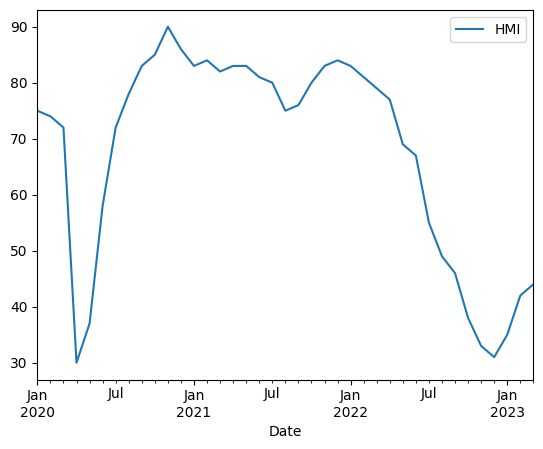

In [7]:
wrangled.query("Year >= 2020").plot(x='Date', y='HMI')

### Plot the mudafakah, bar-style

In [ ]:
wrangled.plot.bar(x='Date', y='HMI')

### Oof...that's fugly.  Do better.

Meh...not really in the mood to retype Matt's code for `matplotlib` stuff.  Neat exercise, but not a good use of my time right now.

I wonder if Chat-GPT 4 could do the heavy lifting for me if I provide it the dataframe and the png of the desired plot???

In [ ]:
def plot_hmi(df):
    for font in ['xtick.color', 'ytick.color', 'axes.labelcolor']:
        matplotlib.rcParams[font] = '#ffffff'
    matplotlib.rcParams['font.family'] = 'Roboto'

    fig = plt.Figure(figsize=(8, 6), dpi=200)
    fig.patch.set_facecolor('#1a1a1a')
    ax = fig.add_axes((.2, .4, .8, .4))
    # cmap = Linear

    return fig

### Recreate in `altair`

In [35]:
# can't do custom color gradients directly in altair but...
# ...you can sample matplotlib's custom gradient and use it in altair
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list('dude_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:9CD2E5-14.7:07AFEB-27.2:48B175-43.4:78C032-72.7:FFc620-100:D02C30
    (0.000, (0.612, 0.824, 0.898)),
    (0.147, (0.027, 0.686, 0.922)),
    (0.272, (0.282, 0.694, 0.459)),
    (0.434, (0.471, 0.753, 0.196)),
    (0.727, (1.000, 0.776, 0.125)),
    (1.000, (0.816, 0.173, 0.188))))

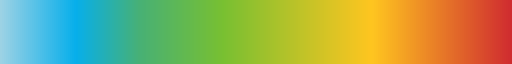

In [36]:
matplotlib_cmap

In [46]:
# define the gradient resolution
gradient_resolution = 1000  # ie, how many distinct colors you want to create in the gradient
# create the sample points from 0 to 1 
gradient_sample_points = np.linspace(0, 1, gradient_resolution)
# sample the matplotlib gradient according to the defined resolution
sampled_gradient = matplotlib_cmap(gradient_sample_points)
# must convert the [R, G, B, alpha] colors to hex values to be useable in altair
hex_colors = [mcolors.to_hex(color) for color in sampled_gradient]
# define/determine the min and max value of the data between mapped
min_value = 0
max_value = 100
# define the altair gradient
altair_gradient = alt.Scale(domain=np.linspace(min_value, max_value + 1, len(hex_colors)), range=hex_colors)

In [70]:
tick_values = np.linspace(-50, 50, 11)
tick_labels = [str(int(i)) for i in np.linspace(0, 100, 11)]

In [73]:
# Create the bar chart
bar_chart = alt.Chart(wrangled).mark_bar().encode(
    x='Date:T',
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-50, 50])),
    # y=alt.Y('y:Q', axis=alt.Axis(values=tick_values, labels=tick_labels)),  # chokes on labels in # or str
    color=alt.Color('HMI:Q', scale=altair_gradient)
).transform_calculate(
    y='datum.HMI - 50'
)

bar_chart.display()


alt.Chart(...)